In [110]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import sys
import datetime
import matplotlib.pyplot as plt
import pyfolio as pf

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
from mlfinlab.data_structures import imbalance_data_structures as imbar, standard_data_structures as bar
import mlfinlab as ml

/mnt/afml/venv/lib/python3.5/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [6]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [7]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)

## Get dollar bar

In [36]:
fname = 'dataset/TRADE_A233740_2018.csv'
bar_fname = 'dataset/DBAR_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)
    
if os.path.exists(bar_fname):
    dbar = pd.read_csv(bar_fname, index_col='date_time')
    dbar.index = pd.to_datetime(dbar.index)
else:
    dbar = bar.get_dollar_bars(fname, threshold=1e8)
    dbar.index = pd.to_datetime(dbar.index)
    dbar.to_csv(bar_fname)

Reading data in batches:
Batch number: 0
Returning bars 



In [37]:
print(df.shape)
print(dbar.shape)

(7647271, 5)
(518545, 5)


In [38]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

In [39]:
def plot_co_events(d0, df, t_barrier_events, num_co_events, avg_uniq): 
    df0 = df.loc[d0]
    t_barrier_events0 = t_barrier_events.loc[d0]
    num_co_events0 = num_co_events.loc[d0]
    avg_uniq0 = avg_uniq.loc[d0]
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)

    plt.title('Triple barriers over the prices')
    plt.plot(df0.index.values, df0.close.values, label='raw_prices', ls='--', color='black')

    # Draw barrier region 
    for i in t_barrier_events0.itertuples(): 
        try: 
            t0, t1, trgt = i.Index, i.t1, i.trgt
            t1 = min(t1, pd.Timestamp("{} 15:30".format(d0)))

            x0 = mdates.date2num(t0)
            x1 = mdates.date2num(t1)
            w = x1 - x0 

            y0 = df0.loc[t0].close * (1 - trgt)
            y1 = df0.loc[t0].close * (1 + trgt)
            h = y1 - y0

            rect = Rectangle((x0, y0), w, h, color='black', alpha=0.05)
            ax.add_patch(rect)

            df1 = df0.loc[[t0, t1]].dropna()

            plt.plot(df1.index.values, df1.close.values, label='triple barrier', ls='--', color='red')
            if df1.shape[0] >= 2:
                plt.scatter(df1.index.values[1], df1.close.values[1], marker='o', linewidths=5, color='red')
                
        except Exception as e:
            print(e)
    plt.show()
    
    # Draw num of co-events
    num_co_events0.plot(kind='bar', figsize=(30,10), label='DV')
    plt.show()
    
    # Draw average uniqueness
    avg_uniq0.plot(kind='bar', figsize=(30,10), label='AvgUniqueness')
    plt.show()

In [40]:
df_sub = df[df.index>datetime.datetime(2018,5,23,9,0)]
df_sub = df_sub[df_sub.index<datetime.datetime(2018,5,24,9,0)]
dbar_sub = dbar[dbar.index>datetime.datetime(2018,5,23,9,0)]
dbar_sub = dbar_sub[dbar_sub.index<datetime.datetime(2018,5,24,9,0)]

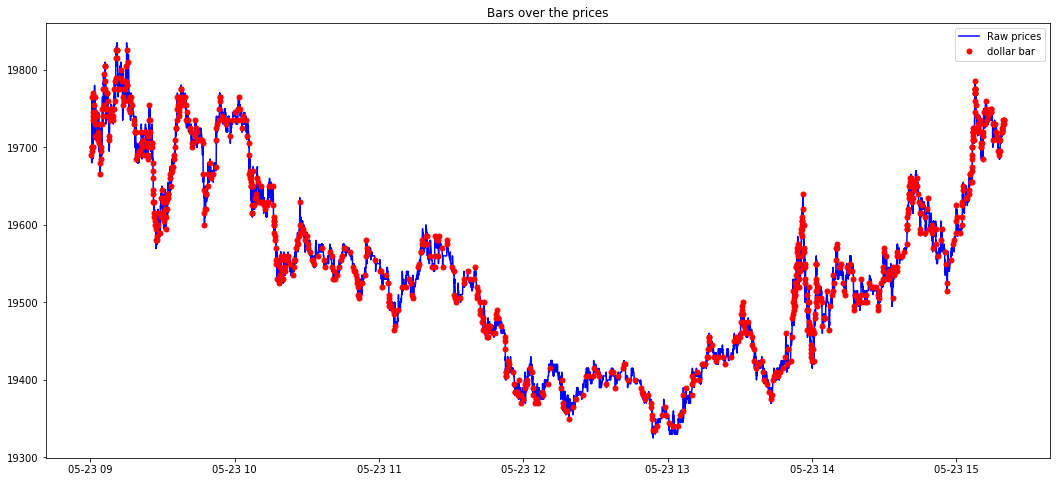

In [41]:
plot_bars(df_sub, dbar_sub, 'dollar bar')

## Apply triple barrier

In [44]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=dbar['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(dbar['close'], threshold=daily_vol.mean()*0.5) # TODO: fix it to watch past value

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=dbar['close'], num_days=1)

In [46]:
print(dbar.shape)
print(cusum_events.shape)
print(vertical_barriers.shape)

(518545, 5)
(73310,)
(73088,)


In [47]:
dbar.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


## Primary - Build Label

In [48]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

/mnt/afml/ml_finance/mlfinlab/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-29 12:57:56.267762 100.0% apply_pt_sl_on_t1 done after 0.32 minutes. Remaining 0.0 minutes.


In [127]:
labels_p = ml.labeling.get_bins(triple_barrier_events, dbar['close'])

In [128]:
labels_p.bin.value_counts()

 1    4637
-1    3566
 0     585
Name: bin, dtype: int64

## Primary - Features

In [51]:
raw_data = dbar.copy()

In [52]:
raw_data.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


In [53]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [54]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [130]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

y = labels_p['bin']

## Primary - Balance classes

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [131]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [132]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

 1    3319
-1    2454
 0     394
Name: bin, dtype: int64

In [ ]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
"""
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()
"""
# class별 blanace 필요

In [133]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

## Primary - Fit a model

In [134]:
parameters = {'max_depth':[2, 4],
              'n_estimators':[2, 10],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [135]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.61115615 0.60499432 0.59542727 0.60239987]
2 2 42


In [136]:
# Refit a new model with best params, so we can see feature importance
rf1 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf1.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Primary - Training metrics

In [141]:
# Performance Metrics
y_pred_rf = rf1.predict_proba(X_train)[:, 1]
y_pred = rf1.predict(X_train)
x_side = y_pred
#fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

# plt.figure(1)
# plt.plot([-1, 1], [-1, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

              precision    recall  f1-score   support

          -1       0.64      0.45      0.53      2454
           0       0.00      0.00      0.00       394
           1       0.61      0.82      0.70      3319

    accuracy                           0.62      6167
   macro avg       0.42      0.42      0.41      6167
weighted avg       0.59      0.62      0.59      6167

Confusion Matrix
[[1112    0 1342]
 [  28    0  366]
 [ 592    0 2727]]

Accuracy
0.6225068915193773


/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Primary - Validation metrics

In [140]:
# Meta-label
# Performance Metrics
y_pred_rf = rf1.predict_proba(X_validate)[:, 1]
y_pred = rf1.predict(X_validate)
x_side = np.concatenate([x_side, y_pred])
# fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

              precision    recall  f1-score   support

          -1       0.67      0.33      0.44       693
           0       0.00      0.00      0.00       104
           1       0.53      0.85      0.65       745

    accuracy                           0.56      1542
   macro avg       0.40      0.39      0.36      1542
weighted avg       0.56      0.56      0.51      1542

Confusion Matrix
[[228   0 465]
 [  5   0  99]
 [109   0 636]]

Accuracy
0.5603112840466926


/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


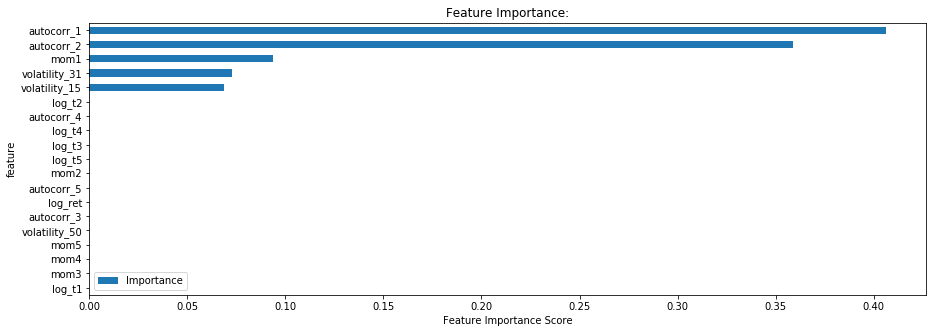

In [142]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf1.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

## Meta Labeling

In [67]:
dbar.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


In [145]:
raw_data = dbar.copy()

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Remove look ahead bias
raw_data = raw_data.shift(1)


In [146]:
raw_data.head()

,open,high,low,close,volume,log_ret,mom1,mom2,mom3,mom4,...,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:03.348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:03.349,19800.0,19980.0,19800.0,19980.0,216028.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:04.614,19980.0,19985.0,19980.0,19985.0,8088.0,0.00025,0.00025,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:06.841,19985.0,19990.0,19980.0,19990.0,6175.0,0.00025,0.00025,0.000501,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00025,NaN,NaN,NaN,NaN
2018-01-02 10:00:10.929,19990.0,19995.0,19985.0,19990.0,7656.0,0.00000,0.00000,0.000250,0.000501,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00025,0.00025,NaN,NaN,NaN


In [147]:
X = raw_data

X.dropna(inplace=True)

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [148]:
total_predict = rf1.predict(X)

In [149]:
total_predict.shape

(518494,)

In [150]:
dbar2 = dbar.loc[X.index]

In [151]:
dbar2['side'] = total_predict

In [152]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar2['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=dbar2['side'])

/mnt/afml/ml_finance/mlfinlab/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-29 16:32:26.911550 100.0% apply_pt_sl_on_t1 done after 0.33 minutes. Remaining 0.0 minutes.


In [153]:
triple_barrier_events.head()

,side,t1,trgt
2018-01-03 10:07:50.640,1.0,2018-01-03 10:28:51.188,0.005499
2018-01-03 10:10:56.199,1.0,2018-01-03 10:28:08.041,0.006182
2018-01-03 14:07:11.526,-1.0,2018-01-03 14:11:35.946,0.005283
2018-01-03 14:07:48.198,-1.0,2018-01-03 14:33:50.656,0.005961
2018-01-03 14:08:05.478,-1.0,2018-01-03 14:17:18.756,0.005959


In [154]:
labels_m = ml.labeling.get_bins(triple_barrier_events, dbar2['close'])
labels_m.side.value_counts()

 1.0    6481
-1.0    2307
Name: side, dtype: int64

In [155]:
labels_m.bin.value_counts()

1    5288
0    3500
Name: bin, dtype: int64

## Meta - Prepare training data

In [156]:
X = raw_data.loc[labels_m.index, :]

In [157]:
X.shape

(8788, 19)

In [158]:
X.columns

Index(['log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility_50',
       'volatility_31', 'volatility_15', 'autocorr_1', 'autocorr_2',
       'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_t1', 'log_t2', 'log_t3',
       'log_t4', 'log_t5'],
      dtype='object')

In [159]:
y = labels['bin']

In [160]:
y.value_counts()

1    5288
0    3500
Name: bin, dtype: int64

## Meta - Balance classes

In [161]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [162]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    3839
0    2328
Name: bin, dtype: int64

In [163]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    2328
0    2328
Name: bin, dtype: int64

In [164]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

## Meta - Fit a model

In [165]:
parameters = {'max_depth':[2, 4],
              'n_estimators':[2, 10],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)    
    clf.fit(X_data, y_data)    
    print(clf.cv_results_['mean_test_score'])    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [166]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.52382471 0.5644293  0.53521525 0.58301412]
10 4 42


In [167]:
# Refit a new model with best params, so we can see feature importance
rf2 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf2.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Meta - Training Metrics

              precision    recall  f1-score   support

           0       0.59      0.61      0.60      2328
           1       0.60      0.58      0.59      2328

    accuracy                           0.59      4656
   macro avg       0.59      0.59      0.59      4656
weighted avg       0.59      0.59      0.59      4656

Confusion Matrix
[[1412  916]
 [ 982 1346]]

Accuracy
0.5923539518900344


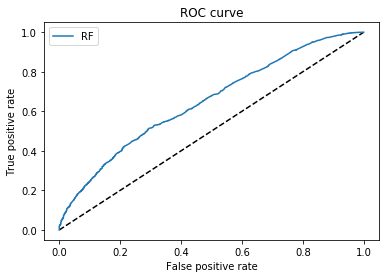

In [168]:
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_train)[:, 1]
y_pred = rf2.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Meta - Validation Metrics

              precision    recall  f1-score   support

           0       0.45      0.63      0.52       678
           1       0.57      0.39      0.47       864

    accuracy                           0.50      1542
   macro avg       0.51      0.51      0.49      1542
weighted avg       0.52      0.50      0.49      1542

Confusion Matrix
[[424 254]
 [523 341]]

Accuracy
0.4961089494163424


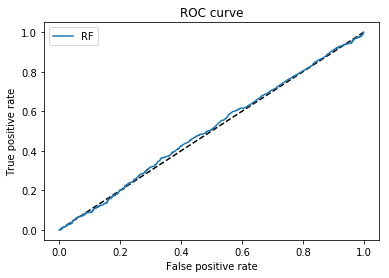

In [169]:
# Meta-label
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_validate)[:, 1]
y_pred = rf2.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [170]:
print(X_validate.index.min())
print(X_validate.index.max())

2018-08-17 10:37:30.141000
2018-10-31 15:16:59.976000


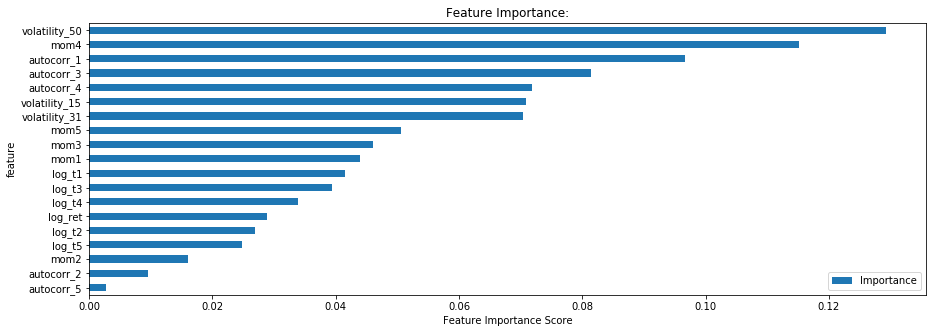

In [171]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf2.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets (In-sample)

## Without Meta Labeling

In [172]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [173]:
valid_dates = X_validate.index
y_pred = rf1.predict(X_validate)
primary_rets = labels.loc[valid_dates, 'ret'].loc[y_pred==1] - labels.loc[valid_dates, 'ret'].loc[y_pred==-1]
primary_model_rets = get_daily_returns(primary_rets)

In [174]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [175]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

,Backtest
Annual return,nan%
Cumulative returns,nan%
Annual volatility,nan%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,NaN
Max drawdown,nan%
Omega ratio,NaN
Sortino ratio,NaN
Skew,NaN


### With Meta Labeling

In [176]:
y_pred = rf2.predict(X_validate)
meta_returns = primary_rets * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [177]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

,Backtest
Annual return,nan%
Cumulative returns,nan%
Annual volatility,nan%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,NaN
Max drawdown,nan%
Omega ratio,NaN
Sortino ratio,NaN
Skew,NaN


---
## Perform out-of-sample test
### Meta Model Metrics

In [208]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-11-01':]
y_oos = y['2018-11-01':]
labels_oos = labels['2018-11-01':]

/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       494
           1       0.55      0.79      0.65       585

    accuracy                           0.43      1079
   macro avg       0.18      0.26      0.22      1079
weighted avg       0.30      0.43      0.35      1079

Confusion Matrix
[[  0   0   0]
 [112   0 382]
 [121   0 464]]

Accuracy
0.43002780352177944


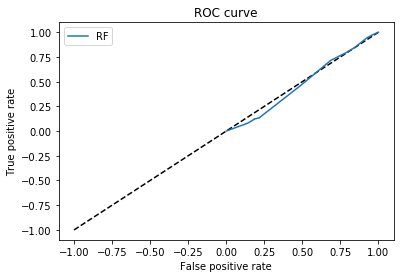

In [179]:
# Primary model
y_pred_rf = rf1.predict_proba(X_oos)[:, 1]
y_pred = rf1.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([-1, 1], [-1, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.45      0.67      0.54       494
           1       0.53      0.31      0.39       585

    accuracy                           0.48      1079
   macro avg       0.49      0.49      0.47      1079
weighted avg       0.49      0.48      0.46      1079

Confusion Matrix
[[331 163]
 [403 182]]

Accuracy
0.47544022242817424


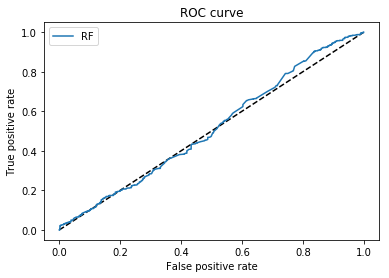

In [180]:
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_oos)[:, 1]
y_pred = rf2.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Primary Model (Test Data)

In [223]:
test_dates = X_oos.index

# Downsample to daily
y_pred = rf1.predict(X_oos)
labels1 = labels_oos.copy()
labels2 = labels_oos.copy()
labels1.loc[labels1.loc[test_dates, 'ret'].loc[y_pred!=1].index,'ret'] = 0
labels2.loc[labels2.loc[test_dates, 'ret'].loc[y_pred!=-1].index,'ret'] = 0
primary_rets = labels1['ret'] - labels2['ret']
daily_rets_prim = get_daily_returns(primary_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

Start date,2018-11-02
End date,2018-12-28
Total months,1
,Backtest
Annual return,2444.2%
Cumulative returns,69.3%
Annual volatility,587.5%
Sharpe ratio,3.27
Calmar ratio,30.76
Stability,0.29
Max drawdown,-79.5%


## Meta Model (Test Data)

Start date,2018-11-02
End date,2018-12-28
Total months,1
,Backtest
Annual return,835.1%
Cumulative returns,43.9%
Annual volatility,246.6%
Sharpe ratio,2.08
Calmar ratio,18.91
Stability,0.50
Max drawdown,-44.2%


/mnt/afml/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,44.17,2018-11-05,2018-11-09,2018-11-19,11
1,41.39,2018-12-03,2018-12-17,NaT,NaN
2,2.02,2018-11-21,2018-11-22,2018-11-26,4
3,0.00,2018-11-02,2018-11-02,2018-11-02,1
4,0.00,2018-11-02,2018-11-02,2018-11-02,1


/mnt/afml/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


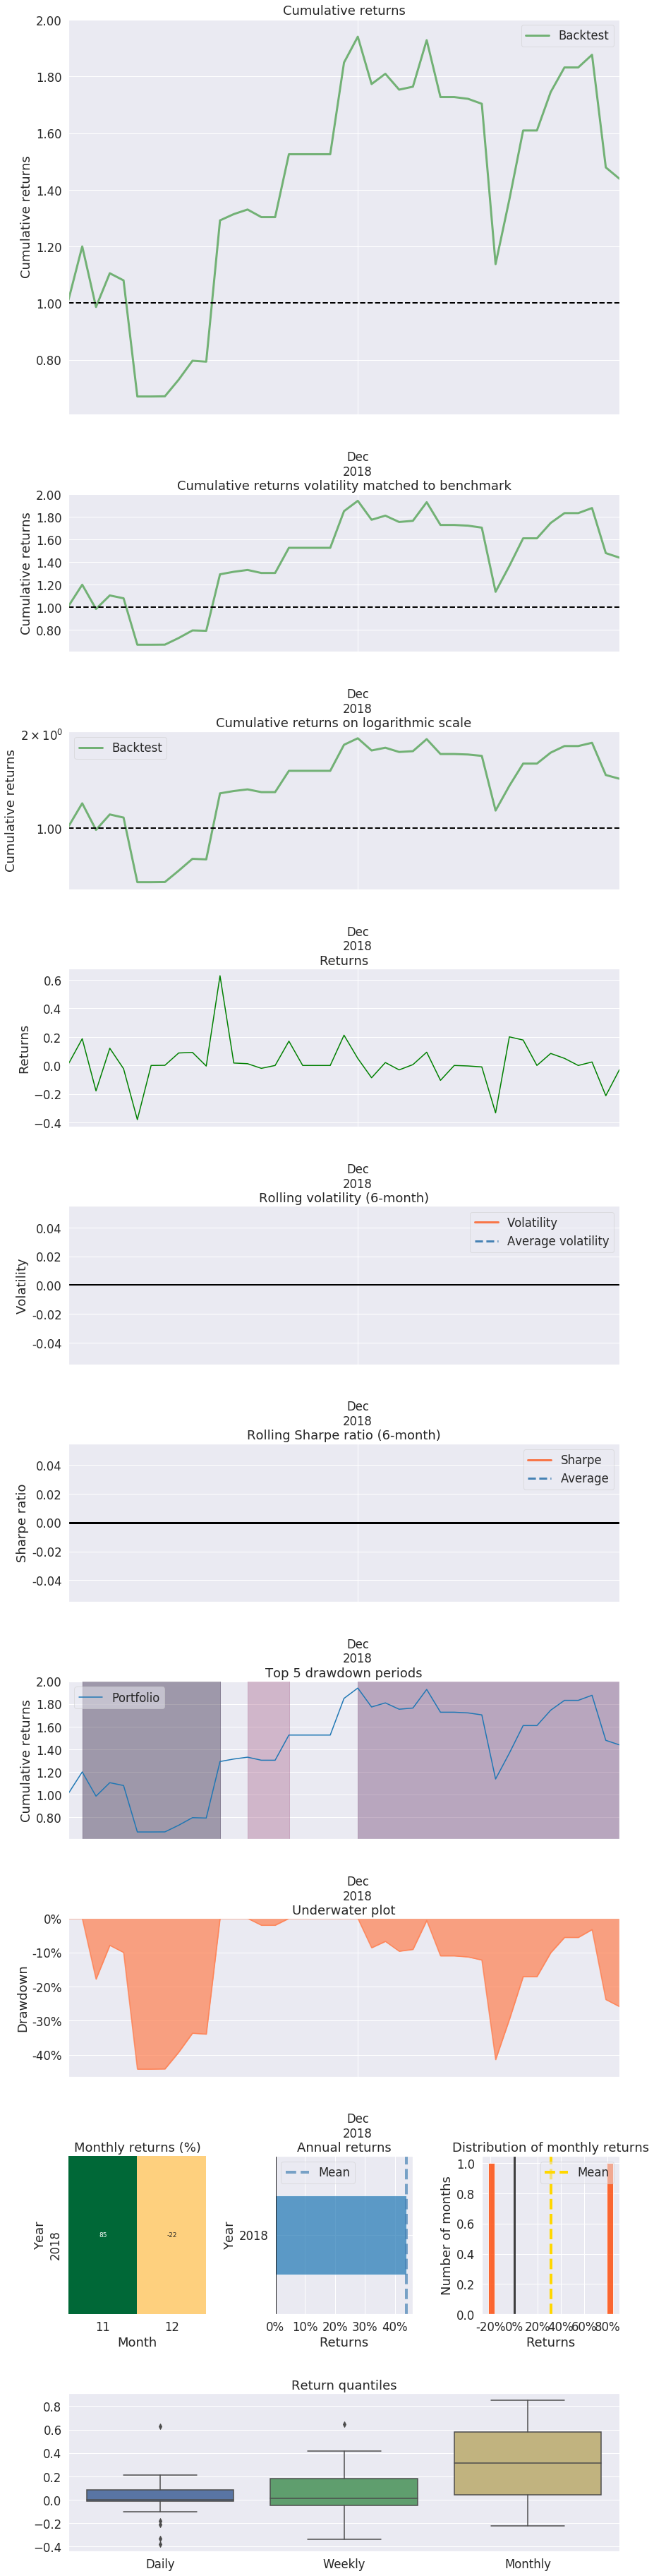

In [221]:
y_pred = rf2.predict(X_oos)
meta_returns = primary_rets * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)